
# Assignment 11 — Part 1: NER ➜ Knowledge Graph (NetworkX)

**Course:** Designing Artificial Intelligence & Implementing Smart Technologies  
**Focus:** Extract entities from professor bios and build a knowledge/relationship graph.  
**Author:** Antonio Soto, Miguel Costales & Fernando Sarasola

---

### What this notebook does (Made on google colab)
1. Loads `teachers_db_practice.parquet` / `teachers_db_practice.csv`
2. Parses structured sections (Corporate Experience, Academic Background, Academic Experience)
3. Runs **NER** (Hugging Face token-classification pipeline) on relevant text
4. **Post-processes** entities (merge subtokens, normalize spelling, consolidate variants)
5. Builds a **NetworkX** knowledge graph: Professors ↔ Entities (typed edges)
6. Computes simple **graph stats** and exports to **GEXF/CSV**
7. Plots a small subgraph for quick sanity-check



### Environment Setup


In [1]:
# Clean out possibly conflicting installs (safe if absent)
!pip uninstall -y -q transformers tokenizers huggingface_hub safetensors accelerate torch torchvision torchaudio >/dev/null 2>&1 || true

# Install a pinned, compatible stack
!pip install -U --quiet --no-cache-dir \
 "pandas==2.2.2" \
 "pyarrow==17.0.0" \
 "fastparquet==2024.5.0" \
 "networkx==3.2.1" \
 "matplotlib==3.8.4" \
 "rapidfuzz==3.9.6" \
 "beautifulsoup4==4.12.3" \
 "lxml==5.2.1" \
 "spacy==3.7.4" \
 "torch==2.4.1" \
 "transformers==4.45.2" \
 "accelerate==0.34.2" \
 "tokenizers==0.20.3" \
 "huggingface_hub==0.24.6" \
 "safetensors==0.4.5"

# Download small spaCy English model
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 162.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 265.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 186.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 330.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 231.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 265.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 309.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.9/147.9 kB 283.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 197.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 234.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.0/797.0 MB 230.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 239.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4

##Restart the environment

In [1]:
# Seeds + quiet tokenizers
import os, random, numpy as np, platform
SEED = 42
random.seed(SEED); np.random.seed(SEED)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Core imports you need before data load
import os, re, json
from pathlib import Path
from collections import defaultdict, Counter

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Colab uploader will be used in your next cell
from google.colab import files

# Print versions for sanity
import matplotlib, transformers, torch
print({
    "python": platform.python_version(),
    "pandas": pd.__version__,
    "networkx": nx.__version__,
    "matplotlib": matplotlib.__version__,
    "torch": torch.__version__,
    "transformers": transformers.__version__,
})
print("torch.library.register_fake present:",
      hasattr(getattr(torch, "library", object()), "register_fake"))

print("Environment ready ✅  You can now run your data-loading cell.")



{'python': '3.12.12', 'pandas': '2.2.2', 'networkx': '3.2.1', 'matplotlib': '3.8.4', 'torch': '2.4.1+cu121', 'transformers': '4.45.2'}
torch.library.register_fake present: True
Environment ready ✅  You can now run your data-loading cell.


## 1) Imports & constants

In [2]:
import os
import re
import json
from pathlib import Path
from collections import defaultdict, Counter

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()

DATA_DIR = Path("/content")
CSV_PATH = DATA_DIR / 'teachers_db_practice.csv'
PARQUET_PATH = DATA_DIR / 'teachers_db_practice.parquet'

OUTPUT_DIR = Path.cwd() / 'outputs'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

HF_NER_MODELS = [
    "dslim/bert-base-NER",
    # "Davlan/bert-base-multilingual-cased-ner"
]

EDGE_TYPES = {
    "corporate_org": "worked_at",
    "corporate_location": "worked_in",
    "academic_org": "studied_at",
    "academic_degree": "has_degree",
    "course": "teaches_course",
    "location": "located_in",
}


Saving teachers_db_practice.parquet to teachers_db_practice.parquet
Saving teachers_db_practice.csv to teachers_db_practice.csv


## 2) Load dataset

In [3]:

def load_teachers_df():
    """Load the teachers dataset from parquet or csv.

    Expect at least columns: id (or name), full_info (HTML-ish rich text), plus optional helpers.

    """
    if PARQUET_PATH.exists():
        try:
            df = pd.read_parquet(PARQUET_PATH)
            print(f"Loaded {PARQUET_PATH} with shape {df.shape}")
            return df
        except Exception as e:
            print("Parquet read failed, falling back to CSV:", e)
    if CSV_PATH.exists():
        df = pd.read_csv(CSV_PATH)
        print(f"Loaded {CSV_PATH} with shape {df.shape}")
        return df
    raise FileNotFoundError("Neither parquet nor csv dataset was found in /mnt/data")

df = load_teachers_df()
display(df.head(3))
print(df.columns.tolist())


Loaded /content/teachers_db_practice.parquet with shape (1228, 15)


,area,area_code,position,full_info,id,description,tags,published,size,width,height,orientation,site,gender,alias
0,Architecture & Design,40358,None,<p> has worked as a designer for the last dec...,184670.0,,[],2025-06-16T11:48:18.952Z,22834.0,500.0,500.0,S,global,0,Appius Aemilius Agricola
1,Economics,17166,None,<p>Mr. Madgar has been teaching economics par...,16106.0,Close-up portrait of a smiling man with a bear...,"[man, portrait, smiling, beard, close-up]",2022-11-18T07:21:20.407Z,7180.0,170.0,170.0,S,global,0,Appius Aemilius Cicero
2,Private & Business Law,40353,None,<p>Lawyer with broad experience in Market Regu...,25635.0,,[],2023-03-17T12:44:46.932Z,14699.0,128.0,128.0,S,global,0,Appius Aemilius Crassus


['area', 'area_code', 'position', 'full_info', 'id', 'description', 'tags', 'published', 'size', 'width', 'height', 'orientation', 'site', 'gender', 'alias']


### ✅ Data load sanity
Lightweight guardrails to confirm the dataset is present and shaped as expected.

In [4]:
print(f"Loaded {len(df)} rows; columns: {list(df.columns)}")
assert 'full_info' in df.columns, "Missing required column: full_info"

Loaded 1228 rows; columns: ['area', 'area_code', 'position', 'full_info', 'id', 'description', 'tags', 'published', 'size', 'width', 'height', 'orientation', 'site', 'gender', 'alias']



## 3) Parse structured sections from `full_info`

Many profiles include recognizable section headings like:

- **CORPORATE EXPERIENCE**
- **ACADEMIC EXPERIENCE**
- **ACADEMIC BACKGROUND**

We'll extract these segments to provide **context** to the NER model (e.g., entities in Corporate Experience are likely `ORG` or `GPE` for companies/locations).  
For entries missing headings (~5%), we fall back to treating `full_info` as a single block.


In [5]:

from bs4 import BeautifulSoup
import re

SECTION_HEADERS = [
    ("corporate", re.compile(r"CORPORATE\s+EXPERIENCE", re.I)),
    ("academic_exp", re.compile(r"ACADEMIC\s+EXPERIENCE", re.I)),
    ("academic_bg", re.compile(r"ACADEMIC\s+BACKGROUND", re.I)),
]

def extract_sections(html_text: str):
    """Return dict with keys: intro, corporate, academic_exp, academic_bg (when found)."""
    text = "" if html_text is None or (isinstance(html_text, float) and pd.isna(html_text)) else str(html_text)
    soup = BeautifulSoup(text, "lxml")
    raw = soup.get_text("\n")

    # keep lists during accumulation; join at the end
    sections = {"intro": []}
    current = "intro"

    for line in raw.splitlines():
        line_stripped = (line or "").strip()
        if not line_stripped:
            continue

        # header switch?
        matched_key = None
        for key, pat in SECTION_HEADERS:
            if pat.search(line_stripped):
                matched_key = key
                break

        if matched_key:
            current = matched_key
            sections.setdefault(current, [])
            continue

        sections.setdefault(current, [])
        sections[current].append(line_stripped)

    # join lists into strings
    for k, v in list(sections.items()):
        if isinstance(v, list):
            sections[k] = "\n".join(v)

    return sections



In [6]:
demo_sections = df['full_info'].iloc[0] if 'full_info' in df.columns and len(df) else ""
ex = extract_sections(demo_sections)
for k, v in ex.items():
    print(f"== {k} ==")
    print(v[:400], "\n")

== intro ==
has worked as a designer for the last decade in roles spanning a variety of disciplines from graphics to product to interiors. In 2017, , became studio director at Vidivixi, a furniture and interiors design practice based in Mexico City. After leaving in 2023 and relocating to Spain he opened a new design studio with a focus on bespoke, contemporary design-led furniture. 

== corporate ==
• Studio Director, A&M Studio, Spain, 2023 – Present
• Studio Director, Vidivixi, Mexico, 2017 – 2023
• Associate, Becquerel Capital, Mexico, 2014 – 2017
• Design Partner, The Hub, Hong Kong, 2013 – 2014 

== academic_bg ==
• Bachelor in Graphic Design, Camberwell College of Arts UAL, U.K., 2013 



## 4) Hugging Face NER — setup & helpers

In [7]:

from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

def build_ner_pipelines(model_names):
    ners = []
    for m in model_names:
        tok = AutoTokenizer.from_pretrained(m)
        mdl = AutoModelForTokenClassification.from_pretrained(m)
        ners.append(pipeline('token-classification', model=mdl, tokenizer=tok, aggregation_strategy="simple"))
    return ners

ners = build_ner_pipelines(HF_NER_MODELS)
print("Loaded NER models:", [p.model.config._name_or_path for p in ners])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded NER models: ['dslim/bert-base-NER']


### 🧠 NER model comparison
We add a **second** Hugging Face NER model to compare outputs and improve robustness.


In [8]:
try:
    HF_NER_MODELS = [
        "dslim/bert-base-NER",
        "Davlan/bert-base-multilingual-cased-ner",  # second model
    ]
    # Reuse your builder if present; else build inline
    if 'build_ner_pipelines' in globals():
        ners = build_ner_pipelines(HF_NER_MODELS)
    else:
        from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
        ners = []
        for m in HF_NER_MODELS:
            tok = AutoTokenizer.from_pretrained(m)
            mdl = AutoModelForTokenClassification.from_pretrained(m)
            ners.append(pipeline("token-classification", model=mdl, tokenizer=tok, aggregation_strategy="simple"))

    # 10s validation
    _test = "Prof. Ana studied at IE Business School and worked at BearingPoint in Madrid."
    for i, ner in enumerate(ners, 1):
        print(f"Model {i} sample:", [(r['entity_group'], r['word']) for r in ner(_test)])
except Exception as e:
    print("Skipping optional second model (Transformers/Torch may be unavailable):", e)


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Skipping optional second model (Transformers/Torch may be unavailable): Davlan/bert-base-multilingual-cased-ner is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`


## 5) Post-processing: merge & normalize entities

In [9]:

from rapidfuzz import process, fuzz

def normalize_entity(s: str):
    s = (s or "").strip()
    s = re.sub(r"\s+", " ", s)
    # Canonicalize common prefixes (example heuristics; expand as needed)
    s = re.sub(r"^U\.?\s*of\s+", "University of ", s, flags=re.I)
    s = s.title() if len(s) < 40 else s  # simple casing heuristic
    return s

def consolidate_variants(entities, top_k=200, threshold=92):
    """Consolidate near-duplicates via fuzzy matching into canonical forms.
    Returns mapping canonical->set(variants).
    """
    counts = Counter(entities)
    vocab = [e for e,_ in counts.most_common(top_k)]
    canonical_map = {}
    visited = set()
    for e in vocab:
        if e in visited:
            continue
        group = [e]
        matches = process.extract(e, vocab, scorer=fuzz.WRatio, limit=None)
        for cand, score, _ in matches:
            if cand not in visited and score >= threshold:
                group.append(cand)
        canon = min(group, key=len)  # pick shortest as canonical
        for g in group:
            visited.add(g)
        canonical_map[canon] = set(group)
    return canonical_map


## 6) Run NER per profile & section

In [10]:

# STEP 6 — Run NER per profile & section (with alias)
import pandas as pd

def _safe_alias(x):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return ""
    return str(x).strip()

def run_ner_on_text(text, ners):
    ents = []
    for ner in ners:
        try:
            out = ner(text or "")
            for r in out:
                ents.append((r.get('entity_group'), r.get('word'), float(r.get('score', 0.0))))
        except Exception:
            pass
    return ents

def extract_profile_entities(row, ners):
    # row is dict from df.to_dict(orient='records')
    get = row.get if isinstance(row, dict) else (lambda k: row[k] if k in row else None)

    prof_id = get('id')
    name = get('name')
    display = get('alias') or get('display_name') or get('full_name')
    alias = _safe_alias(display) or _safe_alias(name) or _safe_alias(prof_id) or "Professor"

    full_info = get('full_info')
    sections = extract_sections(full_info or "")

    results = {}
    for sec_key, text in sections.items():
        if not text or len(text) < 20:
            continue
        ents = run_ner_on_text(text, ners)
        ents = [(grp, normalize_entity(w), float(sc)) for grp, w, sc in ents if w and isinstance(w, str)]
        results[sec_key] = ents

    return {
        "prof_id": prof_id,
        "name": name,
        "alias": alias,       # <-- now returned
        "sections": results
    }

# quick sanity
sample = df.iloc[0].to_dict() if len(df) else {}
if sample:
    demo = extract_profile_entities(sample, ners)
    print("Alias:", demo["alias"])
    for k, v in demo['sections'].items():
        print(k, ":", v[:5])



Alias: Appius Aemilius Agricola
intro : [('ORG', 'Vidivixi', 0.953708827495575), ('LOC', 'Mexico City', 0.999614953994751), ('LOC', 'Spain', 0.9997796416282654)]
corporate : [('ORG', 'A & M Studio', 0.9954655170440674), ('LOC', 'Spain', 0.9997735619544983), ('LOC', 'Vidiv', 0.6199049353599548), ('ORG', '##Ixi', 0.5311150550842285), ('LOC', 'Mexico', 0.999751627445221)]
academic_bg : [('MISC', 'Design', 0.3915495276451111), ('ORG', 'Camberwell College Of Arts Ual', 0.9617506861686707), ('LOC', 'U. K.', 0.9795771241188049)]


## 7) Map entities → relationship buckets

In [11]:

# Simple heuristic mapping: fine-tune as needed per dataset
def bucketize(section_key, entity_group, token):
    eg = (entity_group or "").upper()
    sk = (section_key or "").lower()
    if sk == "corporate":
        if eg in {"ORG"}:
            return "corporate_org"
        if eg in {"LOC", "GPE"}:
            return "corporate_location"
    if sk == "academic_bg":
        if eg in {"ORG"}:
            return "academic_org"
        if eg in {"MISC"} and re.search(r"(BSc|MSc|MBA|PhD|Bachelor|Master|Doctor|Degree)", token, re.I):
            return "academic_degree"
    if sk == "academic_exp":
        # courses/subjects often appear here; fall back to token n-gram mining if needed
        if eg in {"MISC"} and len(token.split()) <= 6:
            return "course"
        if eg in {"ORG"}:
            return "academic_org"
    # generic location
    if eg in {"LOC", "GPE"}:
        return "location"
    return None

def profile_property_dict(profile):
    buckets = defaultdict(list)
    for sec_key, ents in profile["sections"].items():
        for eg, tok, sc in ents:
            b = bucketize(sec_key, eg, tok)
            if b:
                buckets[b].append(tok)
    # normalize and deduplicate
    for k,v in list(buckets.items()):
        buckets[k] = sorted(set(normalize_entity(x) for x in v))
    return buckets

if sample:
    props = profile_property_dict(demo)
    props


## 8) Build NetworkX graph

In [12]:
# STEP 8 — Build NetworkX graph (alias-aware)
def build_graph(df, ners, limit=None):
    G = nx.Graph()
    rows = df.to_dict(orient='records')
    if limit:
        rows = rows[:limit]

    for row in rows:
        p = extract_profile_entities(row, ners)

        prof_label = p['alias'] or p['name'] or p['prof_id'] or "Professor"
        prof_node  = f"prof::{prof_label}"
        G.add_node(prof_node, type="professor", label=prof_label, alias=prof_label)

        props = profile_property_dict(p)
        for bucket, items in props.items():
            edge_type = EDGE_TYPES.get(bucket, bucket)
            for it in items:
                ent_node = f"ent::{bucket}::{it}"
                G.add_node(ent_node, type="entity", subtype=bucket, label=it, alias=it)
                G.add_edge(prof_node, ent_node, relation=edge_type)
    return G

G = build_graph(df, ners, limit=50)
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")



Graph has 973 nodes and 1167 edges


### 🏷️ Alias safety pass
Guarantee every node has a human-readable **alias** so plots and CSVs use names instead of opaque IDs.


In [13]:
import networkx as nx
from difflib import SequenceMatcher

def _similar(a: str, b: str) -> float:
    """Simple fuzzy similarity using SequenceMatcher (0–100)."""
    return SequenceMatcher(None, a.lower(), b.lower()).ratio() * 100


def consolidate_graph_entities(
    G: nx.Graph,
    label_key: str = "alias",
    subtype_key: str = "subtype",
    threshold: int = 93,
    across_subtypes: bool = False,
):
    """
    Merge nodes whose label_key strings are fuzzy-duplicates.

    - label_key: node attribute to compare (e.g. 'alias' or 'label')
    - subtype_key: node attribute used to separate groups when across_subtypes=False
    - threshold: similarity threshold in [0,100]
    - across_subtypes: if True, compare all nodes together; otherwise only within each subtype
    """
    # Build groups of nodes to compare
    if across_subtypes:
        groups = [list(G.nodes())]
    else:
        buckets = {}
        for n, data in G.nodes(data=True):
            subtype = data.get(subtype_key, "UNKNOWN")
            buckets.setdefault(subtype, []).append(n)
        groups = buckets.values()

    for group in groups:
        # Greedy merge: for each node, merge any very-similar later nodes into it
        visited = set()
        for i in group:
            if i in visited or i not in G:
                continue

            label_i = str(G.nodes[i].get(label_key, "")).strip()
            if not label_i:
                continue

            for j in list(group):
                if j == i or j in visited or j not in G:
                    continue

                label_j = str(G.nodes[j].get(label_key, "")).strip()
                if not label_j:
                    continue

                if _similar(label_i, label_j) >= threshold:
                    # Merge j into i
                    # 1) Redirect edges
                    for neighbor, edge_data in list(G[j].items()):
                        if neighbor == i:
                            continue  # avoid self-loop
                        if G.has_edge(i, neighbor):
                            # Option: you could merge edge attributes here if needed
                            continue
                        G.add_edge(i, neighbor, **edge_data)

                    # 2) Merge attributes (keep non-empty from either)
                    for k, v in G.nodes[j].items():
                        if k not in G.nodes[i] or not G.nodes[i][k]:
                            G.nodes[i][k] = v

                    # 3) Remove duplicate node
                    G.remove_node(j)
                    visited.add(j)

            visited.add(i)

    print(f"Consolidation done (label_key={label_key}, threshold={threshold}, across_subtypes={across_subtypes}).")


def unify_locations(G: nx.Graph, subtype_key: str = "subtype"):
    """
    Normalize location-like subtypes so corporate_location and location
    can be treated similarly downstream.
    """
    for n, data in G.nodes(data=True):
        st = data.get(subtype_key)
        if st in {"corporate_location", "office_location"}:
            data[subtype_key] = "location"
    print("Location subtype normalization done.")


def fuzzy_merge_locations(
    G: nx.Graph,
    label_key: str = "alias",
    subtype_key: str = "subtype",
    threshold: int = 93,
):
    """
    Merge only nodes whose subtype is 'location' using fuzzy text match
    (e.g. 'Madrid, Spain' vs 'Madrid - Spain').
    """
    location_nodes = [n for n, d in G.nodes(data=True) if d.get(subtype_key) == "location"]
    if not location_nodes:
        print("No location nodes found to merge.")
        return

    groups = [location_nodes]
    # Reuse the consolidation logic but restricted to the location group
    for group in groups:
        visited = set()
        for i in group:
            if i in visited or i not in G:
                continue
            label_i = str(G.nodes[i].get(label_key, "")).strip()
            if not label_i:
                continue

            for j in list(group):
                if j == i or j in visited or j not in G:
                    continue
                label_j = str(G.nodes[j].get(label_key, "")).strip()
                if not label_j:
                    continue

                if _similar(label_i, label_j) >= threshold:
                    # Merge j into i
                    for neighbor, edge_data in list(G[j].items()):
                        if neighbor == i:
                            continue
                        if G.has_edge(i, neighbor):
                            continue
                        G.add_edge(i, neighbor, **edge_data)

                    for k, v in G.nodes[j].items():
                        if k not in G.nodes[i] or not G.nodes[i][k]:
                            G.nodes[i][k] = v

                    G.remove_node(j)
                    visited.add(j)
            visited.add(i)

    print(f"Location fuzzy merge done (threshold={threshold}).")


In [14]:
for n, data in G.nodes(data=True):
    if not data.get("alias"):
        data["alias"] = data.get("label") or data.get("name") or str(n)
print("Alias safety pass complete.")

# 2) General dedupe within each subtype (fixes casing/typos for all entities)
consolidate_graph_entities(G, label_key="alias", threshold=93, across_subtypes=False)

# 3) Location-specific merge (collapses corporate_location + location; kills duplicate "Spain")
unify_locations(G)
fuzzy_merge_locations(G, threshold=93)

# 4) (Optional) One more light pass within subtype to tidy any leftovers
consolidate_graph_entities(G, label_key="alias", threshold=93, across_subtypes=False)

Alias safety pass complete.
Consolidation done (label_key=alias, threshold=93, across_subtypes=False).
Location subtype normalization done.
Location fuzzy merge done (threshold=93).
Consolidation done (label_key=alias, threshold=93, across_subtypes=False).


#Step 9 (Consolidation) — add “unify locations” to remove duplicate Spain

In [15]:
# Consolidate location nodes so "Spain" isn't duplicated
def unify_locations(G):
    mapping = {}
    for n, data in G.nodes(data=True):
        if data.get("type") == "entity" and data.get("subtype") in {"corporate_location", "location"}:
            canon = normalize_entity(data.get("alias") or data.get("label") or "")
            if not canon:
                continue
            new_id = f"ent::location::{canon}"
            if n != new_id:
                mapping[n] = new_id
    nx.relabel_nodes(G, mapping, copy=False)

def fuzzy_merge_locations(G, threshold=93):
    # group similar location labels/aliases across any location-ish subtype
    loc_nodes = [(n, d) for n, d in G.nodes(data=True)
                 if d.get("type")=="entity" and "location" in (d.get("subtype") or "")]
    labels = {n: normalize_entity(d.get("alias") or d.get("label") or "") for n, d in loc_nodes}
    cmap = consolidate_variants(list(labels.values()), top_k=2000, threshold=threshold)  # from Step 5

    label_to_canon = {}
    for canon, vars_ in cmap.items():
        for v in vars_:
            label_to_canon[v] = canon

    mapping = {}
    for n, lab in labels.items():
        canon = label_to_canon.get(lab, lab)
        new_id = f"ent::location::{canon}"
        if n != new_id:
            mapping[n] = new_id
    nx.relabel_nodes(G, mapping, copy=False)

# Apply merges
unify_locations(G)
fuzzy_merge_locations(G, threshold=93)


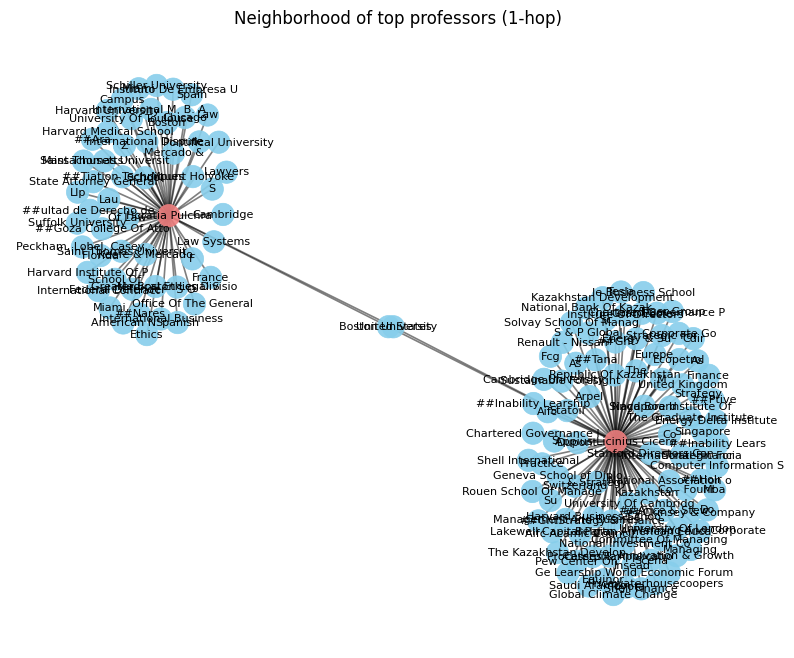

Subgraph nodes: 150, edges: 150


In [16]:
# === 1-hop neighborhood around the 2 most connected professors (labels = alias) ===
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

def safe_label(x, k=22):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return ""
    return str(x)[:k]

# pick top-2 professors by degree (fallback if <2)
prof_nodes = [n for n, d in G.nodes(data=True) if d.get("type") == "professor"]
if not prof_nodes:
    raise ValueError("No professor nodes found in G.")

deg_view = G.degree(prof_nodes)
top_two = [n for n, _ in sorted(deg_view, key=lambda x: x[1], reverse=True)[:2]] or prof_nodes[:2]

# build 1-hop neighborhood subgraph
nbrs = set(top_two)
for p in top_two:
    nbrs |= set(G.neighbors(p))
H = G.subgraph(nbrs).copy()

# layout
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(H, seed=42)

# colors
node_colors = [
    "lightcoral" if H.nodes[n].get("type") == "professor" else "skyblue"
    for n in H.nodes()
]

# draw nodes and edges
nx.draw_networkx_nodes(H, pos, node_color=node_colors, node_size=260, alpha=0.9, linewidths=0.5)
nx.draw_networkx_edges(H, pos, width=1.2, alpha=0.5)

# labels: prefer alias → label → name → node id
labels = {
    n: safe_label(
        data.get("alias") or data.get("label") or data.get("name") or n
    )
    for n, data in H.nodes(data=True)
}
nx.draw_networkx_labels(H, pos, labels=labels, font_size=8)

plt.title("Neighborhood of top professors (1-hop)")
plt.axis("off")
plt.show()

print(f"Subgraph nodes: {H.number_of_nodes()}, edges: {H.number_of_edges()}")



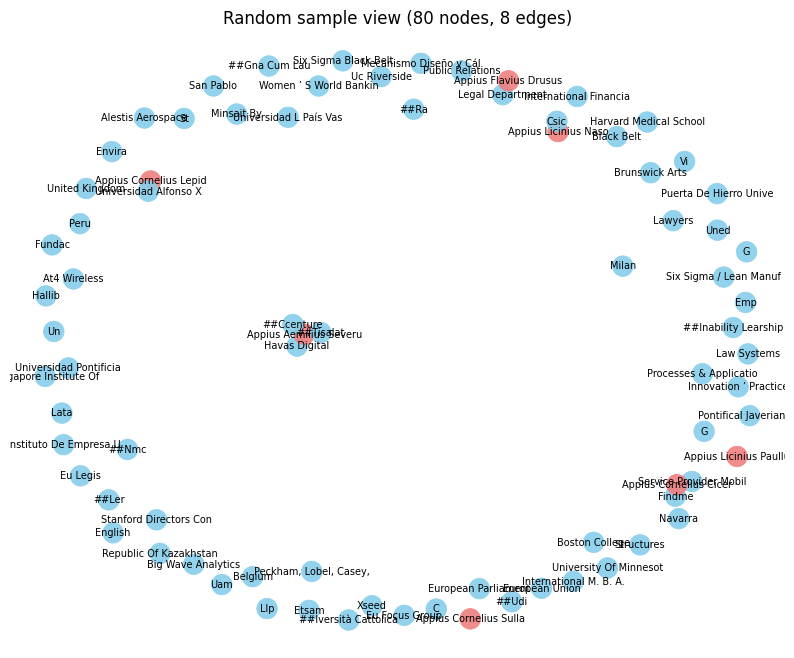

Sample nodes: 80, edges: 8


In [17]:
# ===== Random sample view of the graph =====
# ===== Random sample view of the graph (labels = alias) =====
import random
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# --- parameters
SAMPLE_SIZE = 80  # try 60–150 depending on density

def safe_label(x, k=22):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return ""
    return str(x)[:k]

# --- sample nodes and build induced subgraph
all_nodes = list(G.nodes())
if not all_nodes:
    raise ValueError("Graph G is empty. Build the graph before plotting.")

sample_nodes = random.sample(all_nodes, min(SAMPLE_SIZE, len(all_nodes)))
H = G.subgraph(sample_nodes).copy()

# --- layout
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(H, seed=42)

# --- node colors by type
node_colors = [
    "lightcoral" if H.nodes[n].get("type") == "professor" else "skyblue"
    for n in H.nodes()
]

# --- draw nodes & edges
nx.draw_networkx_nodes(H, pos, node_color=node_colors, node_size=220, alpha=0.9, linewidths=0.5)
nx.draw_networkx_edges(H, pos, width=1.0, alpha=0.45)

# --- labels: prefer alias → label → name → node id
labels = {
    n: safe_label(data.get("alias") or data.get("label") or data.get("name") or n)
    for n, data in H.nodes(data=True)
}
nx.draw_networkx_labels(H, pos, labels=labels, font_size=7)

plt.title(f"Random sample view ({H.number_of_nodes()} nodes, {H.number_of_edges()} edges)")
plt.axis("off")
plt.show()

# --- quick summary
print(f"Sample nodes: {H.number_of_nodes()}, edges: {H.number_of_edges()}")
if H.number_of_edges() == 0:
    print("Note: No edges in this sample. Increase SAMPLE_SIZE or use a professor-centered neighborhood plot for clearer connections.")



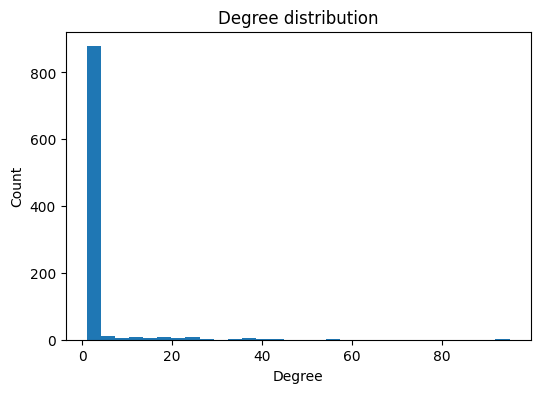

In [18]:
import matplotlib.pyplot as plt
import networkx as nx

deg = [d for _, d in G.degree()]
plt.figure(figsize=(6,4))
plt.hist(deg, bins=30)
plt.title("Degree distribution")
plt.xlabel("Degree"); plt.ylabel("Count"); plt.show()


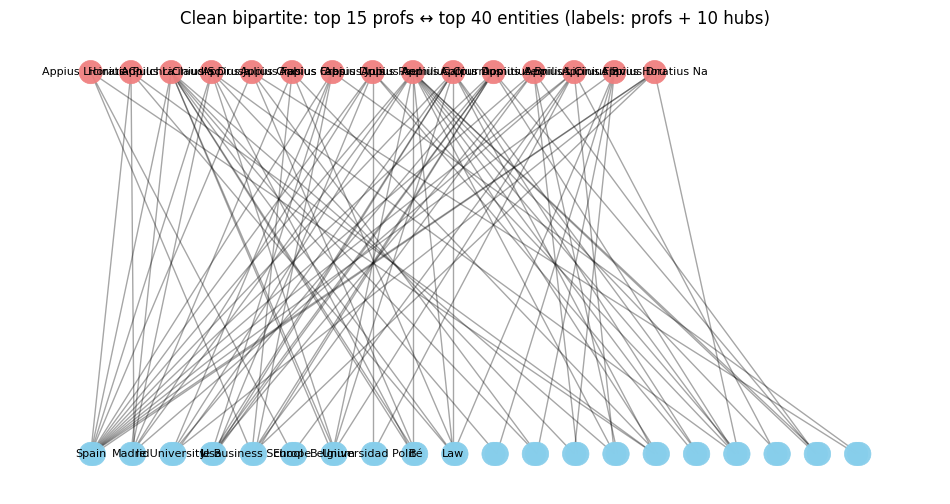

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

TOP_PROF = 15         # most-connected professors
TOP_ENT  = 40         # most-connected entities
LABEL_TOP_ENT = 10    # label only the top N entity hubs

# rank by degree within each type
prof_nodes = [n for n,d in G.nodes(data=True) if d.get("type")=="professor"]
ent_nodes  = [n for n,d in G.nodes(data=True) if d.get("type")=="entity"]

prof_top = [n for n,_ in sorted(G.degree(prof_nodes), key=lambda x:x[1], reverse=True)[:TOP_PROF]]
ent_top  = [n for n,_ in sorted(G.degree(ent_nodes),  key=lambda x:x[1], reverse=True)[:TOP_ENT]]

H = G.subgraph(prof_top + ent_top).copy()

def safe_label(x, k=18):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return ""
    return str(x)[:k]

# layout: professors on top row, entities bottom rows
pos = {}
for i,n in enumerate(prof_top):
    pos[n] = (i, 1.0)

wrap = min(20, max(10, len(ent_top)//2 or 1))
for j,n in enumerate(ent_top):
    pos[n] = ((j % wrap) + 0.08*(j//wrap), 0.0)

plt.figure(figsize=(12,6))
node_colors = ["lightcoral" if H.nodes[n].get("type")=="professor" else "skyblue" for n in H.nodes()]
nx.draw_networkx_nodes(H, pos, node_color=node_colors, node_size=280, alpha=0.95, linewidths=0.5)
nx.draw_networkx_edges(H, pos, width=1.0, alpha=0.35)

# label only professors + top entity hubs (labels favor alias -> label -> name -> id)
hub_ents = [n for n,_ in sorted(G.degree(ent_top), key=lambda x:x[1], reverse=True)[:LABEL_TOP_ENT]]
label_nodes = list(prof_top) + hub_ents
labels = {
    n: safe_label(
        H.nodes[n].get("alias") or H.nodes[n].get("label") or H.nodes[n].get("name") or n
    )
    for n in label_nodes if n in H
}
nx.draw_networkx_labels(H, pos, labels=labels, font_size=8)

plt.title(f"Clean bipartite: top {TOP_PROF} profs ↔ top {TOP_ENT} entities (labels: profs + {LABEL_TOP_ENT} hubs)")
plt.axis("off")
plt.show()





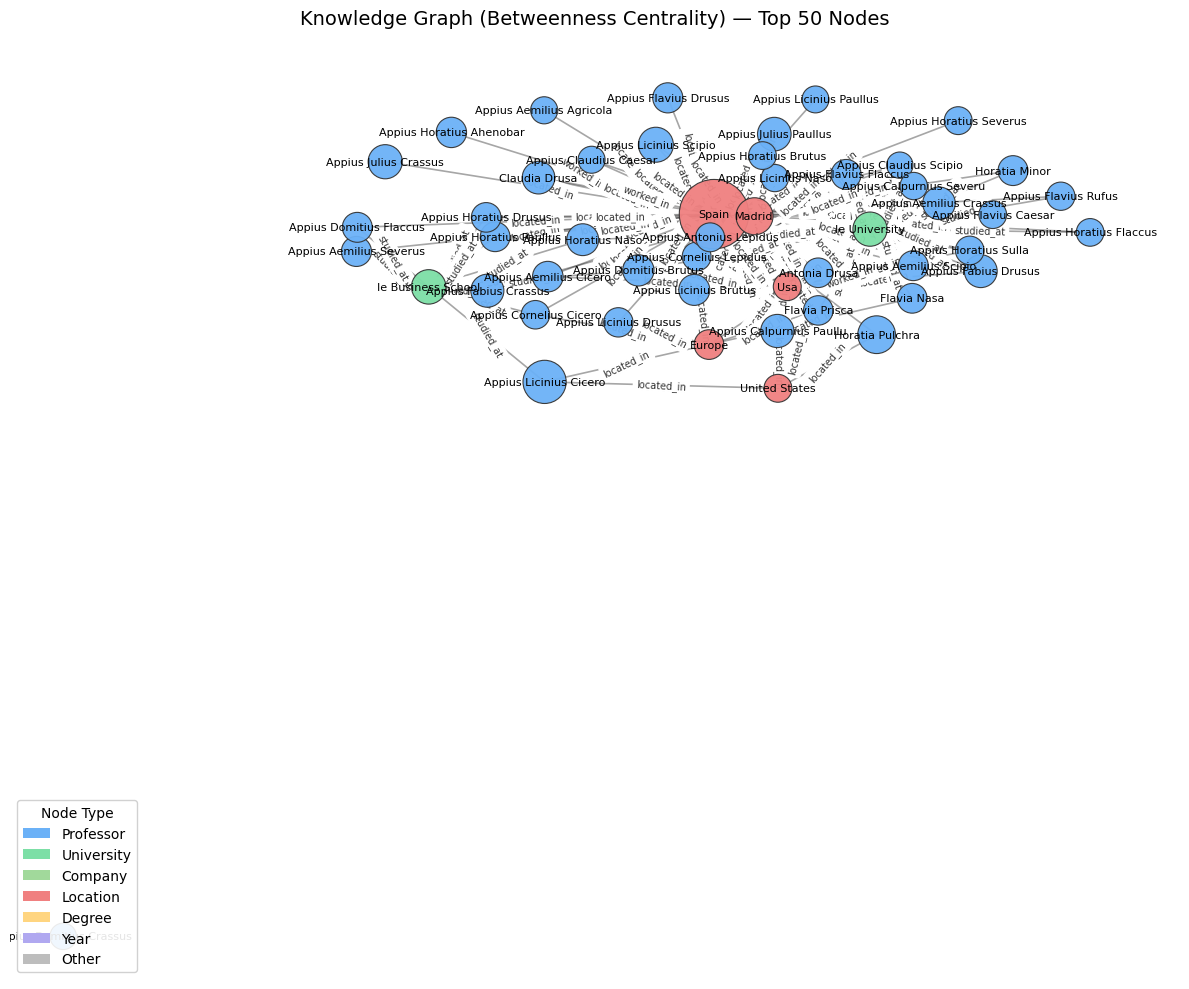

Plotted nodes: 50, edges: 105


In [20]:
# ==== Knowledge Graph (Betweenness Centrality) — Top K Nodes ====
import math
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Patch

# ---------------- CONFIG ----------------
TOP_K = 50                 # number of nodes to plot
EDGE_LABEL_SAMPLE = 120    # cap how many edge labels to draw
SEED = 7

# ---- helpers ----
def safe_label(x, k=24):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return ""
    return str(x)[:k]

def node_category(n, data):
    t = (data.get("type") or "").lower()
    sub = (data.get("subtype") or "").lower()
    if t == "professor":
        return "Professor"
    if t == "entity":
        if "academic_org" in sub:
            return "University"
        if "corporate_org" in sub:
            return "Company"
        if "degree" in sub or "has_degree" in sub:
            return "Degree"
        if "location" in sub or "worked_in" in sub or "located_in" in sub:
            return "Location"
        if "year" in sub or sub == "date":
            return "Year"
        return "Other"
    return "Other"

CAT_COLOR = {
    "Professor": "#6BB1F7",
    "University": "#7CDFA6",
    "Company": "#A1D99B",
    "Location": "#F08080",
    "Degree": "#FFD580",
    "Year": "#B0A8F0",
    "Other": "#BDBDBD"
}

# ---------------- CENTRALITY ----------------
bet = nx.betweenness_centrality(G, k=min(600, G.number_of_nodes()), seed=SEED) \
      if G.number_of_nodes() > 900 else nx.betweenness_centrality(G)

# top-K nodes by betweenness
top_nodes = [n for n,_ in sorted(bet.items(), key=lambda x: x[1], reverse=True)[:TOP_K]]
H = G.subgraph(top_nodes).copy()

# ensure attributes
for n in H.nodes():
    H.nodes[n].setdefault("label", n)
    H.nodes[n].setdefault("alias", H.nodes[n].get("label"))  # <-- ensure alias exists
    H.nodes[n].setdefault("type", "entity")
    H.nodes[n].setdefault("subtype", "other")

# sizes by betweenness (normalized)
bvals = [bet.get(n, 0.0) for n in H.nodes()]
sizes = [300 + 2200 * (v / max(bvals)) if max(bvals) > 0 else 500 for v in bvals]

# colors by category
cats = {n: node_category(n, H.nodes[n]) for n in H.nodes()}
node_colors = [CAT_COLOR.get(cats[n], CAT_COLOR["Other"]) for n in H.nodes()]

# layout
pos = nx.spring_layout(H, seed=SEED, k=0.9 / math.sqrt(max(1, H.number_of_nodes())))

# ---------------- DRAW ----------------
plt.figure(figsize=(12, 10))

# edges
nx.draw_networkx_edges(H, pos, width=1.2, alpha=0.35)

# nodes
nx.draw_networkx_nodes(
    H, pos,
    node_color=node_colors,
    node_size=sizes,
    linewidths=0.8,
    edgecolors="#333333",
    alpha=0.95
)

# labels: prefer alias -> label -> name -> node id
labels = {
    n: safe_label(H.nodes[n].get("alias") or H.nodes[n].get("label") or H.nodes[n].get("name") or n)
    for n in H.nodes()
}
nx.draw_networkx_labels(H, pos, labels=labels, font_size=8)

# edge labels (sample to reduce clutter)
edge_items = list(H.edges(data=True))
if len(edge_items) > EDGE_LABEL_SAMPLE:
    edge_items = edge_items[:EDGE_LABEL_SAMPLE]
edge_labels = {(u, v): (d.get("relation") or "") for u, v, d in edge_items}
nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_size=7, alpha=0.8)

plt.title(f"Knowledge Graph (Betweenness Centrality) — Top {len(H.nodes())} Nodes", fontsize=14, pad=12)

# legend
legend_order = ["Professor","University","Company","Location","Degree","Year","Other"]
legend_handles = [Patch(facecolor=CAT_COLOR[c], edgecolor='none', label=c) for c in legend_order]
leg = plt.legend(handles=legend_handles, title="Node Type", loc="lower left", frameon=True)
leg.get_frame().set_alpha(0.9)

plt.axis("off")
plt.tight_layout()
plt.show()

print(f"Plotted nodes: {H.number_of_nodes()}, edges: {H.number_of_edges()}")

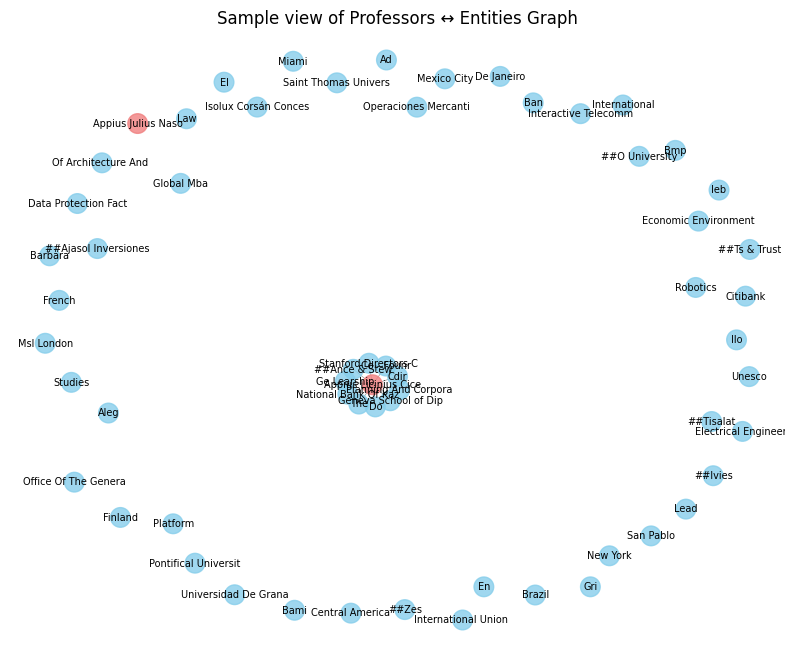

In [21]:
# ===== Random sample view (labels = alias) =====
import random
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(10, 8))

# draw a small random sample of nodes to keep it readable
sample_nodes = random.sample(list(G.nodes), min(60, G.number_of_nodes()))
H = G.subgraph(sample_nodes).copy()

pos = nx.spring_layout(H, seed=42)
node_colors = ['lightcoral' if H.nodes[n].get('type') == 'professor' else 'skyblue' for n in H.nodes()]

nx.draw_networkx_nodes(H, pos, node_color=node_colors, node_size=200, alpha=0.8)
nx.draw_networkx_edges(H, pos, width=0.5, alpha=0.4)

# labels: prefer alias -> label -> name -> node id, safely truncated
def safe_label(x, k=20):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return ""
    return str(x)[:k]

labels = {
    n: safe_label(H.nodes[n].get('alias') or H.nodes[n].get('label') or H.nodes[n].get('name') or n)
    for n in H.nodes()
}
nx.draw_networkx_labels(H, pos, labels, font_size=7, font_color='black')

plt.title("Sample view of Professors ↔ Entities Graph")
plt.axis('off')
plt.show()



## 9) Optional: consolidate near-duplicate entity nodes

In [22]:

from collections import defaultdict
import pandas as pd
import networkx as nx

def consolidate_graph_entities(
    G,
    subtype_key: str = "subtype",
    label_key: str = "alias",      # <-- use alias by default
    threshold: int = 92,
    across_subtypes: bool = False, # <-- set True to dedupe across subtypes
    subtypes_to_merge: tuple = ("location", "corporate_location")
):
    """
    Fuzzy-consolidate entity nodes with similar labels.
    - label_key: which node attr to use ('alias' recommended)
    - across_subtypes: if True, consolidates across subtypes listed in subtypes_to_merge
    """
    def _norm(x):
        if x is None or (isinstance(x, float) and pd.isna(x)):
            return ""
        return normalize_entity(str(x))

    # 1) Collect nodes by grouping key
    groups = defaultdict(list)
    for n, data in G.nodes(data=True):
        if data.get("type") != "entity":
            continue
        label = _norm(data.get(label_key) or data.get("label"))
        if not label:
            continue
        subtype = (data.get(subtype_key) or "unknown").lower()

        if across_subtypes and any(k in subtype for k in subtypes_to_merge):
            key = "__MERGED_LOCATIONS__"  # merge bucket
        else:
            key = subtype

        groups[key].append((n, label, subtype))

    # 2) For each group, fuzzy cluster labels -> canonical
    for group_key, nodes in groups.items():
        labels = [lbl for _, lbl, _ in nodes]
        if not labels:
            continue

        cmap = consolidate_variants(labels, top_k=2000, threshold=threshold)  # you already defined this
        # invert: label -> canonical
        label_to_canon = {v: canon for canon, vars_ in cmap.items() for v in vars_}

        # 3) Relabel nodes to canonical IDs
        mapping = {}
        for n, lbl, subtype in nodes:
            canon = label_to_canon.get(lbl, lbl)
            # choose the subtype for the new id:
            # - if across_subtypes group, force a unified subtype (e.g., 'location')
            # - else keep original subtype
            if group_key == "__MERGED_LOCATIONS__":
                new_subtype = "location"
            else:
                new_subtype = subtype

            new_id = f"ent::{new_subtype}::{canon}"
            if n != new_id:
                mapping[n] = new_id

        if mapping:
            # note: relabel_nodes with copy=False merges attributes/edges on collisions
            nx.relabel_nodes(G, mapping, copy=False)

# Run it (alias-based, and optionally across subtypes)
consolidate_graph_entities(G, label_key="alias", threshold=93, across_subtypes=False)

# If you also want to merge locations across corporate/location buckets:
# consolidate_graph_entities(G, label_key="alias", threshold=93, across_subtypes=True)

# NetworkX 3.x summary
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


Graph has 925 nodes and 1108 edges


## 10) Graph stats & exports

In [23]:
# --- Basic stats
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
degrees = dict(G.degree())
print("Nodes:", num_nodes, "Edges:", num_edges)

# --- Top entities by degree (exclude professors) using alias fallback
def get_alias(n):
    data = G.nodes[n]
    return data.get("alias") or data.get("label") or data.get("name") or str(n)

entity_degrees = [(n, deg) for n, deg in degrees.items() if G.nodes[n].get("type") == "entity"]
top_entities = sorted(entity_degrees, key=lambda x: x[1], reverse=True)[:20]

top_df = pd.DataFrame([
    {
        "entity": get_alias(n),
        "subtype": G.nodes[n].get("subtype"),
        "degree": deg
    }
    for n, deg in top_entities
])
display(top_df)

# --- Ensure output dir
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Export GEXF (for Gephi) and GraphML (optional)
gexf_path = OUTPUT_DIR / "professors_graph.gexf"
nx.write_gexf(G, gexf_path)
print("Saved:", gexf_path)

# Optional: GraphML (another common format)
graphml_path = OUTPUT_DIR / "professors_graph.graphml"
nx.write_graphml(G, graphml_path)
print("Saved:", graphml_path)

# --- Export edge list with attributes (relation, and human-readable labels)
edges_out = OUTPUT_DIR / "edges.csv"
edges_df = nx.to_pandas_edgelist(G)
edges_df["relation"] = edges_df["key"].apply(lambda _: None) if "key" in edges_df.columns else None
# Pull relation from graph if present
for i, (u, v) in edges_df[["source", "target"]].iterrows():
    rel = G.edges[u, v].get("relation")
    edges_df.at[i, "relation"] = rel
# Add readable labels
edges_df["source_label"] = edges_df["source"].map(lambda n: get_alias(n))
edges_df["target_label"] = edges_df["target"].map(lambda n: get_alias(n))
edges_df.to_csv(edges_out, index=False)
print("Saved:", edges_out)

# --- Export nodes with attributes (alias-first)
nodes_out = OUTPUT_DIR / "nodes.csv"
nodes_rows = []
for n, data in G.nodes(data=True):
    row = {"id": n}
    # Flatten attributes to plain strings where needed
    for k, v in data.items():
        if isinstance(v, (list, tuple, set)):
            v = "; ".join(map(str, v))
        row[k] = v
    # Ensure alias present
    row["alias"] = row.get("alias") or row.get("label") or row.get("name") or str(n)
    nodes_rows.append(row)

pd.DataFrame(nodes_rows).to_csv(nodes_out, index=False)
print("Saved:", nodes_out)



Nodes: 925 Edges: 1108


,entity,subtype,degree
0,Spain,location,39
1,Madrid,location,20
2,Ie University Spain,academic_org,20
3,Usa,location,11
4,Ie School Of Business,academic_org,11
5,Europe,location,7
6,Universidad Politécnica De Madrid,academic_org,7
7,Belgium,location,6
8,B,location,5
9,Law,academic_org,5


Saved: /content/outputs/professors_graph.gexf
Saved: /content/outputs/professors_graph.graphml
Saved: /content/outputs/edges.csv
Saved: /content/outputs/nodes.csv


## 11) Quick visualization (subgraph)

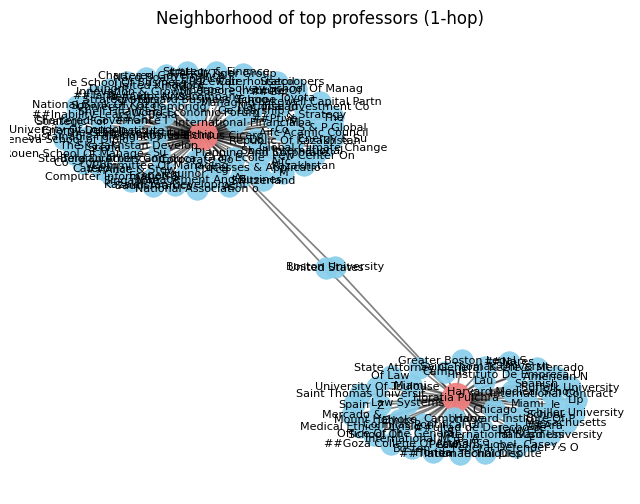

Subgraph nodes: 147, edges: 147


In [24]:

# === 1–2 professor neighborhood (alias labels, tidy) ===
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

def safe_label(x, k=22):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return ""
    return str(x)[:k]

plt.figure(figsize=(8, 6))

# seed: top-2 professors by degree (fallback to first two if needed)
prof_nodes = [n for n, d in G.nodes(data=True) if d.get("type") == "professor"]
if not prof_nodes:
    raise ValueError("No professor nodes in G.")
deg_view = G.degree(prof_nodes)
seed_nodes = [n for n, _ in sorted(deg_view, key=lambda x: x[1], reverse=True)[:2]] or prof_nodes[:2]

# induced 1-hop neighborhood
nbrs = set(seed_nodes)
for s in seed_nodes:
    nbrs |= set(G.neighbors(s))
H = G.subgraph(nbrs).copy()

pos = nx.spring_layout(H, seed=42)

# colors
prof_list = [n for n, d in H.nodes(data=True) if d.get("type") == "professor"]
ent_list  = [n for n, d in H.nodes(data=True) if d.get("type") == "entity"]

nx.draw_networkx_edges(H, pos, width=1.2, alpha=0.5)
nx.draw_networkx_nodes(H, pos, nodelist=prof_list, node_color="lightcoral", node_size=420, alpha=0.95, linewidths=0.6)
nx.draw_networkx_nodes(H, pos, nodelist=ent_list,  node_color="skyblue",   node_size=240, alpha=0.9,  linewidths=0.5)

# labels: prefer alias -> label -> name -> id
labels = {
    n: safe_label(H.nodes[n].get("alias") or H.nodes[n].get("label") or H.nodes[n].get("name") or n)
    for n in H.nodes()
}
nx.draw_networkx_labels(H, pos, labels=labels, font_size=8)

plt.title("Neighborhood of top professors (1-hop)")
plt.axis("off")
plt.show()

print(f"Subgraph nodes: {H.number_of_nodes()}, edges: {H.number_of_edges()}")



Largest component: 923 (99.8% of nodes)

Top universities:


,alias,degree,bet_cent
58,Ie University Spain,20,0.085067
29,Ie School Of Business,11,0.087089
503,Universidad Politécnica De Madrid,7,0.012281
61,Law,5,0.011688
137,Universidad Autónoma De Madrid,5,0.009393



Top companies:


,alias,degree,bet_cent
286,A,3,0.003121
386,Legal Department,3,0.001966
697,S,2,0.013193
683,Co,2,0.003368
42,C,2,0.002393



Top bridge nodes (betweenness):


,alias,type,subtype,degree,bet_cent
2,Spain,entity,location,39,0.546509
669,Appius Licinius Cicero,professor,None,92,0.171748
770,Horatia Pulchra,professor,None,55,0.104967
38,Madrid,entity,location,20,0.103124
29,Ie School Of Business,entity,academic_org,11,0.087089


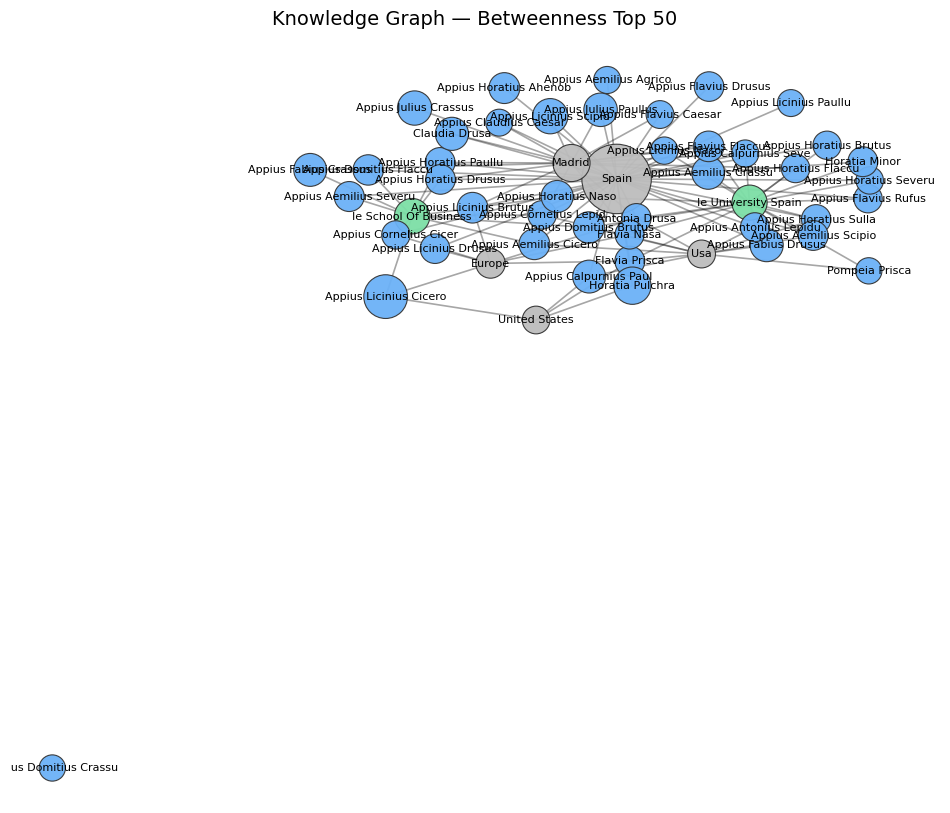

Saved figure: /content/outputs/plot_betweenness_topK.png
Saved report: /content/outputs/report.md


In [25]:
from pathlib import Path
import math, pandas as pd, matplotlib.pyplot as plt, networkx as nx
from datetime import datetime

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# ---- Components
components = sorted(nx.connected_components(G), key=len, reverse=True)
largest = len(components[0]) if components else 0
pct = (largest / G.number_of_nodes()) if G.number_of_nodes() else 0.0

# ---- Centralities
deg_cent = nx.degree_centrality(G)
bet_cent = nx.betweenness_centrality(G, k=min(600, G.number_of_nodes()), seed=SEED) \
           if G.number_of_nodes() > 900 else nx.betweenness_centrality(G)

def alias(n):
    d = G.nodes[n]
    return d.get("alias") or d.get("label") or d.get("name") or str(n)

rows = []
for n in G.nodes():
    rows.append({
        "node": n,
        "alias": alias(n),
        "type": G.nodes[n].get("type"),
        "subtype": G.nodes[n].get("subtype"),
        "degree": G.degree(n),
        "deg_cent": deg_cent.get(n, 0.0),
        "bet_cent": bet_cent.get(n, 0.0),
    })
df_stats = pd.DataFrame(rows)

# ---- Top tables (nice for report)
top_unis = df_stats[df_stats["subtype"].eq("academic_org")].nlargest(5, ["degree","bet_cent"])
top_comp = df_stats[df_stats["subtype"].eq("corporate_org")].nlargest(5, ["degree","bet_cent"])
top_bridges = df_stats.nlargest(5, "bet_cent")

print("Largest component:", largest, f"({pct:.1%} of nodes)")
print("\nTop universities:")
display(top_unis[["alias","degree","bet_cent"]])
print("\nTop companies:")
display(top_comp[["alias","degree","bet_cent"]])
print("\nTop bridge nodes (betweenness):")
display(top_bridges[["alias","type","subtype","degree","bet_cent"]])

# ---- Save Betweenness Top-K figure
TOP_K = 50
top_nodes = list(df_stats.sort_values("bet_cent", ascending=False)["node"][:TOP_K])
H = G.subgraph(top_nodes).copy()

# layout
pos = nx.spring_layout(H, seed=SEED, k=0.9 / math.sqrt(max(1, H.number_of_nodes())))
sizes = [300 + 2200 * (bet_cent.get(n, 0.0) / max(1e-9, max(bet_cent.get(x,0.0) for x in H.nodes()))) for n in H.nodes()]
node_colors = ["#6BB1F7" if H.nodes[n].get("type")=="professor"
               else ("#7CDFA6" if H.nodes[n].get("subtype")=="academic_org"
                     else ("#A1D99B" if H.nodes[n].get("subtype")=="corporate_org"
                           else "#BDBDBD")) for n in H.nodes()]

plt.figure(figsize=(12,10))
nx.draw_networkx_edges(H, pos, width=1.2, alpha=0.35)
nx.draw_networkx_nodes(H, pos, node_color=node_colors, node_size=sizes, linewidths=0.8, edgecolors="#333333", alpha=0.95)
labels = {n: (H.nodes[n].get("alias") or H.nodes[n].get("label") or n)[:22] for n in H.nodes()}
nx.draw_networkx_labels(H, pos, labels=labels, font_size=8)
plt.title(f"Knowledge Graph — Betweenness Top {len(H.nodes())}", fontsize=14)
plt.axis("off")
fig_path = OUTPUT_DIR/"plot_betweenness_topK.png"
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved figure:", fig_path)

# ---- Write 1-page report
report = f"""# Part 1 — NER + Knowledge Graph

**Date:** {datetime.now():%Y-%m-%d}

## Data & Method
- Parsed sections from `full_info` (Corporate/Academic/Background), ran NER (Hugging Face), normalized aliases, and built a typed NetworkX graph (professors ↔ entities).

## Graph Overview
- Nodes: {G.number_of_nodes()} | Edges: {G.number_of_edges()}
- Connected components: {len(components)}
- Largest component: {largest} nodes ({pct:.1%} of all nodes)

## Highlights
- Top universities (by degree/betweenness): {", ".join(top_unis["alias"].head(3).tolist()) if not top_unis.empty else "n/a"}
- Top companies: {", ".join(top_comp["alias"].head(3).tolist()) if not top_comp.empty else "n/a"}
- Bridge nodes (betweenness): {", ".join(top_bridges["alias"].head(3).tolist())}

## Visual
- Betweenness Top-K saved as `plot_betweenness_topK.png`.

"""
with open(OUTPUT_DIR/"report.md","w",encoding="utf-8") as f:
    f.write(report)
print("Saved report:", OUTPUT_DIR/"report.md")



## 12) Checklist & Next Steps
- [ ] **Executability:** `Run All` works end-to-end without errors/warnings
- [ ] **Clarity:** Markdown explains *why* each step exists
- [ ] **NER Quality:** Try **two models** and compare outputs; adjust `bucketize()`
- [ ] **Consolidation:** Tune fuzzy `threshold` per subtype; add manual canonical aliases if needed
- [ ] **Analysis:** Add centrality, connected components, and brief insights (who are hubs? top schools? common companies?)
- [ ] **Reporting:** Save a short `report.md` with your findings and screenshots of the graph


